# Assigment 3
## Ex. 3

In [0]:
%matplotlib notebook
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
signal_length = 15
signal_repeats = 3
predict_ahead = 1
noise_strength = 0.00
total_series_length = signal_length * signal_repeats

Input: sinus signal $\sin(x_t)$

Target: same signal but predict_ahead steps ($\delta$) shifted (predict to future) $\sin(x_{t+\delta})$

In [0]:
dims = 1
def generateData(signal_length, predict_ahead, signal_repeats, batch_size, noise_strength):
    total_series_length = signal_length*signal_repeats
    x = np.linspace(0, np.pi*2*signal_repeats, total_series_length + predict_ahead, dtype=np.float32)
    x = x.reshape((1, -1, 1))  
    
    # include shift for batches
    x = np.repeat(x, batch_size, 0)
    x += np.random.random(batch_size)[:, None, None] * 10
    y = np.sin(x)
    input_ = y[:, :total_series_length].copy()
    if noise_strength > 0:
        input_ += np.random.normal(size=(input_.shape)) * noise_strength # add some noise to the input
    target = y[:, predict_ahead:]
    return input_ , target 

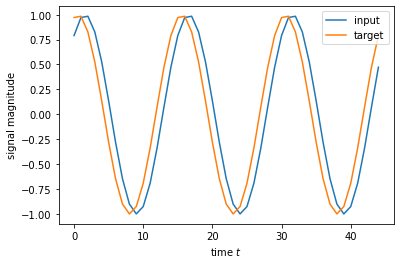

In [0]:
x, y = generateData(signal_length, predict_ahead, signal_repeats, 1, noise_strength)
x_i, y_i = x[0, :, 0], y[0, :, 0]
f, ax = plt.subplots(1)
ax.plot(x_i, label="input")
ax.plot(y_i, label="target")
ax.set_xlabel("time $t$")
ax.set_ylabel("signal magnitude")
ax.legend()

# Recurrent Neural Network (RNN)
**fully-connected-layer** is defined as:

$\mathbf{o} \leftarrow \sigma \left( W \cdot \mathbf{x} + \mathbf{b} \right)$
* activation function $\sigma$ (e.g. ReLU, tanH)
* weight matrix $W \in \mathbb{R}^{m \times d}$
* number of neurons $m$ and dimensionality $d$ of input $\mathbf{x} = (x_1 , \ldots , x_d)$
* bias vector $\mathbf{b}$
* output $\mathbf{o}$
* Notation *differences* to the neural networks slides from Christian:
    * activation: $\sigma$ = $h$
    * number of neurons: $m$ = $M$
    * input dimensionality: $d$ = $d$
    * bias: $\mathbf{b}$ = $w_0$
    * layer output: $\mathbf{o}$ = $a$

**RNN-layer** is defined as:

$ \mathbf{o} \leftarrow \mathbf{h}_t \leftarrow \sigma \bigl( W \cdot \mathbf{x}_t +$ 
<font color=red> $ U \cdot \mathbf{h}_{t-1} $</font>
$ + \mathbf{b} \bigr) $

* the output $\mathbf{o}$ is also the hidden state $\mathbf{h}$ at time $t$
* input are time steps of the series: $\left( \ldots, \mathbf{x}_{t-1}, \mathbf{x}_{t},  \mathbf{x}_{t+1}, \ldots \right)$
* previous hidden state $h_{t-1}$ or the "memory" has its own weight matrix $U \in \mathbb{R}^{m \times m}$


## Sequence Tasks
![image](http://karpathy.github.io/assets/rnn/diags.jpeg)
(input red, hidden green, output blue)

**one to one**:
* from fixed-sized input to fixed-sized output
* example: image classification

**one to many**:
* fixed-sized input to sequence output
* example: image captioning (image to sequence of words), music generation (image to music)

**many to one**:
* sequence input to fixed-sized output
* example: sentiment analysis (twitter to positive/negative sentiment), Heart-Rate sequence to sleep circle classification

**many to many (async)**:
* sequence input to sequence output
* example: text translation, music generation (continuation of piece or style transfer)

**many to many (sync)**:
* sequence input to sequence output
* example: video annotation, continous weather forecast

## Simple Recurrent Networks (SRN)
 $\renewcommand{\hat}[1]{\widehat{#1}}$
**Elman network** (used here): 
    
$ \mathbf{h}_t \leftarrow \sigma_h \bigl( W_h \cdot \mathbf{x}_t + U_h \cdot \mathbf{h}_{t-1} + \mathbf{b}_h \bigr) $

$ \hat{\mathbf{y}}_t \leftarrow \sigma_y \bigl( W_y \cdot \mathbf{h}_t + \mathbf{b}_y \bigr) $

Computational Graph:
![image](attachment:rnn.svg)


**Jordan network**:

$ \mathbf{h}_t \leftarrow \sigma_h \bigl( W_h \cdot \mathbf{x}_t + U_h \cdot $ <font color=red> $ \hat{\mathbf{y}}_{t-1} $ </font> $ + \mathbf{b}_h \bigr) $

$ \hat{\mathbf{y}}_t \leftarrow \sigma_y \bigl( W_y \cdot \mathbf{h}_t + \mathbf{b}_y \bigr) $

* output prediction $ \hat{\mathbf{y}} $
* activation function $\sigma_h$ for recurrent layer (e.g. tanH)
* activation function $\sigma_y$ for output layer (e.g. linear, sigmoid)

Algorithm to process a time series with $T$ elements: <br />
>**for** $t$ from 1 to $T$ **do:**
> >    $\mathbf{u}_t \leftarrow W_h \cdot \mathbf{x}_t  + U_h \cdot \mathbf{h}_{t-1} + \mathbf{b}_h$ <br />
> >    $\mathbf{h}_t \leftarrow \sigma_h \bigl(\mathbf{u}_t)$ <br />
> >    $\mathbf{o}_t \leftarrow W_y \cdot \mathbf{h}_t + \mathbf{b}_y $ <br />
> >    $\hat{\mathbf{y}}_t \leftarrow \sigma_y \bigl( \mathbf{o}_t \bigr)$ <br />
>
> **end for** <br />
> **Return** $[\hat{\mathbf{y}}]_{t=1}^T$


### Loss Function and Derivatives
whenever the output is a sequence, the loss function can be seen as:

$\mathcal{L}_T(\hat{\mathbf{y}}, \mathbf{y}) =  \sum_{t=1}^{T} \mathcal{L}(\hat{\mathbf{y}}_t, \mathbf{y}_t)$, with $T$ being the length of the series

Derivatives are coming from the backpropagation through time algorithm (Werbos 1990; Rummerhart *et al.* 1986):

>**for** $t$ from T down to $1$ **do:**
> >    $ d\mathbf{o}_t \leftarrow  \sigma'_y( \mathbf{o}_t ) \cdot d\mathcal{L}(\mathbf{\hat{y}}_t, \mathbf{y}_t)/ d\hat{\mathbf{y}}_t    $ <br />
> >
> >
> >    $ d\mathbf{b}_y \leftarrow d\mathbf{b}_y + d\mathbf{o}_t $ <br />
> >    $ dW_y \leftarrow dW_y + d\mathbf{o}_t \cdot \mathbf{h}_t^\top $ <br />
> >    $ d\mathbf{h}_t \leftarrow d\mathbf{h}_t + W_y^\top \cdot d\mathbf{o}_t $ <br />
> >
> >
> >
> >
> >    $ d\hat{\mathbf{y}}_t \leftarrow \sigma'_h(\hat{\mathbf{y}}) + d\mathbf{h}_t $ <br />
> >
> >
> >
> >    $ dW_h \leftarrow dW_h + d\hat{\mathbf{y}}_t \cdot \mathbf{x}_t^\top $ <br />
> >    $ dU_h \leftarrow dU_h + d\hat{\mathbf{y}}_t \cdot \mathbf{h}_{t-1}^\top $ <br />
> >    $ d\mathbf{b}_h \leftarrow d\mathbf{b}_h + d\hat{\mathbf{y}}_t $ <br />
> >
> >
> >
> >    $ d\hat{\mathbf{h}}_{t-1} \leftarrow U_h^\top \cdot \hat{\mathbf{y}} $ <br />
>
> **end for** <br />
> **Return** $d\Theta = [dW_h, dU_h, dW_y, d\mathbf{b}_h, d\mathbf{b}_y, d\mathbf{h}_0]$

#### Remarks:
*  if eigenvalues of $U_h$ are smaller than 1 we quickly encounter the vanishing gradient problem since the $d\hat{\mathbf{y}}_t \cdot \mathbf{h}_{t-1}^\top$ term will quickly tend to zero
* if one time step creates large outputs, it can create the opposite effect: exploding gradients
* this makes training on very long time series problematic and unstable

### Truncated Backpropagation Through Time (TBPTT)

**Problem**: for very long time series the gradient might vanish/explode over time

**Solution**: Instead of iterating through the complete series at once, we seperate it into smaller chunks, but keep the hidden state from the previous chunk.

**BPTT(size, stride)**
* stride: how often backpropagation per timestep is applied 
* size: how many timesteps per backpropagation pass are considered

**Different variants**:
* stride = size (current standard implementation)
![stride = size](https://r2rt.com/static/images/RNN_tf_truncated_backprop.png)
* stride < size (extreme: stride=1)
![stride < size](https://r2rt.com/static/images/RNN_true_truncated_backprop.png)

![Stride.svg](attachment:Stride.svg)

Can be seen as *rolling window calculation* of errors.


## Creating a SRN model

In [0]:
# learn a better initial hidden state representation (True) than zero init
learn_h0 = False
# learn a better initial cell state representation (True) than zero init
learn_c0 = False
# number of weight update iterations
n_iterations = 250
# size and stride of window for truncated backprop through time 
truncated_backprop_length = 15
# number of neurons m in the hidden layer
num_neurons = 8
batch_size = 5
lr = 0.01

first, initialize the learnable weights and biases (parameters):

### Parameters of the LSTM

In [0]:
# Initialize forget gate parameters
W_f = tf.Variable(np.random.rand(dims, num_neurons), dtype=tf.float32)
U_f = tf.Variable(np.random.rand(num_neurons, num_neurons), dtype=tf.float32)
b_f = tf.Variable(np.zeros((1, num_neurons)), dtype=tf.float32)
# Initialize input gate parameters
W_i = tf.Variable(np.random.rand(dims, num_neurons), dtype=tf.float32)
U_i = tf.Variable(np.random.rand(num_neurons, num_neurons), dtype=tf.float32)
b_i = tf.Variable(np.zeros((1, num_neurons)), dtype=tf.float32)
# Initialize modulation gate parameters
W_j = tf.Variable(np.random.rand(dims, num_neurons), dtype=tf.float32)
U_j = tf.Variable(np.random.rand(num_neurons, num_neurons), dtype=tf.float32)
b_j = tf.Variable(np.zeros((1, num_neurons)), dtype=tf.float32)
# Initialize output gate parameters
W_o = tf.Variable(np.random.rand(dims, num_neurons), dtype=tf.float32)
U_o = tf.Variable(np.random.rand(num_neurons, num_neurons), dtype=tf.float32)
b_o = tf.Variable(np.zeros((1, num_neurons)), dtype=tf.float32)
# Initialize hidden state
h_0 = tf.Variable(np.zeros((1, num_neurons), dtype=np.float32))
# Initialize cell state
c_0 = tf.Variable(np.zeros((1, num_neurons), dtype=np.float32))

## Parameters of the (fully-connected) output layer

In [0]:
# Initialize dense layer parameters
W_y = tf.Variable(np.random.rand(num_neurons, dims), dtype=tf.float32)
b_y = tf.Variable(np.zeros((1, dims)), dtype=tf.float32)

create the forward pass for a single time step and an itertions function

$ \mathbf{h}_t \leftarrow \sigma_h \bigl( W_h \cdot \mathbf{x}_t + U_h \cdot \mathbf{h}_{t-1} + \mathbf{b}_h \bigr) $

$ \hat{\mathbf{y}}_t \leftarrow \sigma_y \bigl( W_y \cdot \mathbf{h}_t + \mathbf{b}_y \bigr) $

In [0]:
@tf.function
def step(x_t, c, h):
    ## LSTM layer
    # Forget gate
    f = tf.nn.tanh(
        tf.matmul(x_t, W_f) + tf.matmul(h, U_f) + b_f
    )
    # Input gate
    i = tf.nn.tanh(
        tf.matmul(x_t, W_i) + tf.matmul(h, U_i) + b_i
    )
    # Modulation gate
    j = tf.nn.tanh(
        tf.matmul(x_t, W_j) + tf.matmul(h, U_j) + b_j
    )  
    # Output gate
    o = tf.nn.tanh(
        tf.matmul(x_t, W_o) + tf.matmul(h, U_o) + b_o
    )  
    # Cell state
    c = f * c + i * j
    # Hidden state
    h = o * tf.nn.tanh(c) 

    ## Dense layer
    y_hat = tf.matmul(h, W_y) + b_y
    return y_hat, c, h # Returning prediction, cell and hidden state

@tf.function
def iterate_series(x, c, h):
    y_hat = []
    # iterate over time axis (1)
    for t in range(x.shape[1]):
        # give previous hidden state and input from the current time step
        y_hat_t, c, h = step(x[:, t], c, h)
        y_hat.append(y_hat_t)
    y_hat = tf.stack(y_hat, 1)
    return y_hat, c, h

for backpropagation we use Adam, but we could use any optimizer from tf.keras.optimizer (or write our own)

In [0]:
# Define which parameters get updated during the gradient step
trainable_vars = [W_f, U_f, b_f, W_i, U_i, b_i, W_j, U_j, b_j, W_o, U_o, b_o, W_y, b_y]
if learn_h0:
    trainable_vars.append(h_0)
if learn_c0:
    trainable_vars.append(c_0)

# standard optimizer SGD or AdaGrad would also work
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

## Training the model

In [0]:
# just a helper function to see the progress
def replot(input_series, predictions_series, batchY, f, ax,  input_line, y_line, pred_line, text, iteration, loss):
    y_line.set_xdata(range(total_series_length))
    y_line.set_ydata(batchY)
    pred_line.set_xdata(range(total_series_length))
    pred_line.set_ydata(predictions_series)
    input_line.set_xdata(range(total_series_length))
    input_line.set_ydata(input_series)
    text.set_text(f"Iteration: {iteration} Loss: {loss}")
#     plt.pause(0.25)
    
    # Need both of these in order to rescale
    ax.relim()
    ax.autoscale_view()
    # We need to draw and flush
    f.canvas.draw()
    f.canvas.flush_events()
    f.savefig("test.pdf")

Training loss 0.006231256


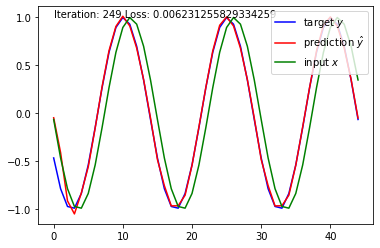

In [0]:
plt.ion()
f, ax = plt.subplots(1)
y_line, = ax.plot([],[], color="blue", label="target $y$")
pred_line, = ax.plot([],[], color="red", label="prediction $\haty$")
input_line, = ax.plot([],[], color="green", label="input $x$")
text = ax.text(0, 1, "", )
ax.legend(loc='upper right')

# train for a set number of iterations
for iteration in range(n_iterations):
    # generates a long time series / normally loaded from dataset (e.g. stocks, weather)
    x, y = generateData(signal_length, predict_ahead, signal_repeats, batch_size, noise_strength)
    h = None
    predictions = None
    loss_list = []
    grads = None
    
    # do not feed complete series, but chunks of it (truncated_backprop_length)
    for i in range(0, total_series_length, truncated_backprop_length):
        
        # record any gradient "action" in the following section
        with tf.GradientTape() as tape:
            if h is None:
                # initialize cell state (c_0) and hidden state (h_0)
                c = tf.repeat(c_0, batch_size, 0)
                h = tf.repeat(h_0, batch_size, 0)
            # create chunks of input/target data with our defined truncated backprop length
            x_part = x[:, i: i + truncated_backprop_length]
            y_part = y[:, i: i + truncated_backprop_length]

            # get predictions for this part (forward pass)
            y_hat, c, h = iterate_series(x_part, c, h)

            # calculate mean squared error
            loss = tf.reduce_mean((y_hat - y_part)**2)        
        # backprop
        if grads is None: # first part
            grads = tape.gradient(loss, trainable_vars)
        else:
            grads = grads + tape.gradient(loss, trainable_vars)

        loss_list.append(loss)
        # combine with previous predictions
        predictions = tf.concat([predictions, y_hat], 1) if predictions is not None else y_hat
    
    # finally we are adapting the weights with the saved gradient information
    optimizer.apply_gradients(zip(grads, trainable_vars))
        
    # plot model predictions during training
    replot(x[0], predictions[0], y[0], f, ax, input_line, y_line, pred_line, text, iteration, np.mean(loss_list))

print("Training loss", np.mean(loss_list))

# Free Running RNN (Generating)
to make continous predictions 

In [0]:
def free_running(x_0, c, h, time_steps):
    y_hat = []
    y_hat_t = x_0
    # iterate over time axis (1)
    for t in range(time_steps):
        # give previous hidden state and input from the current time step
        y_hat_t, c, h = step(y_hat_t, c, h)
        y_hat.append(y_hat_t)
    y_hat = tf.stack(y_hat, 1)
    return y_hat, c, h

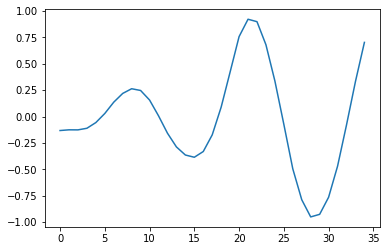

In [0]:
batch_s = 1
# initialize hidden state (h_0) with zeros
c_ar = tf.repeat(c_0, batch_size, 0)
h_ar = tf.repeat(h_0, batch_size, 0)

# initial (single) value for x
x_0 = np.random.uniform(-1, 1, size=(batch_s, 1)).astype(np.float32)

# any length possible here
length = 35
# get predictions for "lenght" time steps (can be seen as forecast that is as long as the defined length)
y_hat, c_ar, h_ar = free_running(x_0, c_ar, h_ar, length)

f, ax = plt.subplots(1)
ax.plot(y_hat[0, :, 0])
